In [1]:
from keras.models import load_model

Using TensorFlow backend.


In [2]:
model = load_model('my_model.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [3]:
model

In [4]:
datadir = 'test/'

In [5]:
import glob
d0 = glob.glob(datadir+'/*')

In [6]:
import scipy
i0 = scipy.misc.imread(d0[0],mode='RGB')

/home/deepanshu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


In [8]:
import numpy as np
I = np.array(scipy.misc.imread(d0[0], mode='RGB'))

/home/deepanshu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


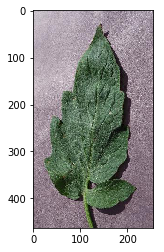

In [10]:
import matplotlib.pyplot as plt
plt.imshow(I)
plt.show()

In [11]:
def new_dims(dims):
    smaller = min(dims)
    w_min = int((dims[0]-smaller)/2)
    w_max = int(dims[0]-w_min)
    h_min = int((dims[1]-smaller)/2)
    h_max = int(dims[1]-h_min)

    return ((w_min,w_max),(h_min,h_max))

In [12]:
nd = [new_dims(s) for s in sizes]

NameError: name 'sizes' is not defined

In [14]:
sizes = np.array(i.shape[:2])

NameError: name 'i' is not defined

In [ ]:
Ip = np.array([scipy.misc.imresize(
    ii[nn[0][0]:nn[0][1],nn[1][0]:nn[1][1]]
    ,(224,224),'cubic','RGB') for ii,nn in zip(I,nd)
])

In [7]:
plt.imshow(Ip[1])

numpy.ndarray

In [ ]:
num_data = len(glob.glob(datadir + '/*'))
all_imgs = np.zeros((num_data,224,224,3),dtype=np.uint8)
labels = np.zeros((num_data,num_classes),dtype=np.float16)

In [ ]:
cnt = 0
for i,c in enumerate(classes):
    images = glob.glob(c+'/*')
    for im in tqdm(images):
        img_tmp = scipy.misc.imread(im,mode='RGB')
        s = img_tmp.shape[:2]
        nn = new_dims(s)
        all_imgs[cnt] = scipy.misc.imresize(
        img_tmp[nn[0][0]:nn[0][1],nn[1][0]:nn[1][1]]
        ,(224,224),'cubic','RGB')
        labels[cnt][i] = 1
        cnt += 1

In [ ]:
all_imgs = all_imgs.transpose((0,3,1,2))

In [15]:
model.predict(I)

ValueError: Error when checking : expected convolution2d_input_1 to have 4 dimensions, but got array with shape (463, 256, 3)

In [1]:
import cv2
import numpy as np
import os         
from random import shuffle
from tqdm import tqdm   
TRAIN_DIR = '/home/deepanshu/Desktop/new_test/PlantDiseaseDetection/train/train'
TEST_DIR = '/home/deepanshu/Desktop/new_test/PlantDiseaseDetection/test/test'
IMG_SIZE = 50
LR = 1e-3
MODEL_NAME = 'healthyvsunhealthy-{}-{}.model'.format(LR, '2conv-basic')

def label_img(img):
    word_label = img[0]
  
    if word_label == 'h': return [1,0,0,0]
    
    elif word_label == 'b': return [0,1,0,0]
    elif word_label == 'v': return [0,0,1,0]
    elif word_label == 'l': return [0,0,0,1]

def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

train_data = create_train_data()

import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import tensorflow as tf
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 3], name='input')

convnet = conv_2d(convnet, 32, 3, activation='relu')
convnet = max_pool_2d(convnet, 3)

convnet = conv_2d(convnet, 64, 3, activation='relu')
convnet = max_pool_2d(convnet, 3)

convnet = conv_2d(convnet, 128, 3, activation='relu')
convnet = max_pool_2d(convnet, 3)

convnet = conv_2d(convnet, 32, 3, activation='relu')
convnet = max_pool_2d(convnet, 3)

convnet = conv_2d(convnet, 64, 3, activation='relu')
convnet = max_pool_2d(convnet, 3)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 4, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=8, validation_set=({'input': test_x}, {'targets': test_y}),
    snapshot_step=40, show_metric=True, run_id=MODEL_NAME)

model.save(MODEL_NAME)


Training Step: 439  | total loss: 0.05320 | time: 9.961s
| Adam | epoch: 008 | loss: 0.05320 - acc: 0.9856 -- iter: 3456/3500
Training Step: 440  | total loss: 0.05165 | time: 11.134s
| Adam | epoch: 008 | loss: 0.05165 - acc: 0.9855 | val_loss: 0.18742 - val_acc: 0.9480 -- iter: 3500/3500
--
INFO:tensorflow:/home/deepanshu/Desktop/healthyvsunhealthy-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


In [2]:
model

In [3]:
import tkinter as tk
from tkinter.filedialog import askopenfilename
import shutil
import os
import sys
from PIL import Image, ImageTk

In [29]:
load = Image.open('/home/deepanshu/Desktop/new_test/PlantDiseaseDetection/test/test/7b29fda8-5d5a-4158-827d-9941is')

FileNotFoundError: [Errno 2] No such file or directory: '/home/deepanshu/Desktop/new_test/PlantDiseaseDetection/test/test/7b29fda8-5d5a-4158-827d-9941is'

In [27]:
def analysis():
    import cv2  # working with, mainly resizing, images
    import numpy as np  # dealing with arrays
    import os  # dealing with directories
    from random import shuffle  # mixing up or currently ordered data that might lead our network astray in training.
    from tqdm import \
        tqdm  # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion
    verify_dir = '/home/deepanshu/Desktop/new_test/PlantDiseaseDetection/testpicture'
    IMG_SIZE = 50
    LR = 1e-3
    MODEL_NAME = 'healthyvsunhealthy-{}-{}.model'.format(LR, '2conv-basic')

    def process_verify_data():
        verifying_data = []
        for img in tqdm(os.listdir(verify_dir)):
            path = os.path.join(verify_dir, img)
            img_num = img.split('.')[0]
            img = cv2.imread(path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            verifying_data.append([np.array(img), img_num])
        np.save('verify_data.npy', verifying_data)
        return verifying_data

    verify_data = process_verify_data()
    #verify_data = np.load('verify_data.npy')

    import tflearn
    from tflearn.layers.conv import conv_2d, max_pool_2d
    from tflearn.layers.core import input_data, dropout, fully_connected
    from tflearn.layers.estimator import regression
    import tensorflow as tf
    tf.reset_default_graph()

    convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 3], name='input')

    convnet = conv_2d(convnet, 32, 3, activation='relu')
    convnet = max_pool_2d(convnet, 3)

    convnet = conv_2d(convnet, 64, 3, activation='relu')
    convnet = max_pool_2d(convnet, 3)

    convnet = conv_2d(convnet, 128, 3, activation='relu')
    convnet = max_pool_2d(convnet, 3)

    convnet = conv_2d(convnet, 32, 3, activation='relu')
    convnet = max_pool_2d(convnet, 3)

    convnet = conv_2d(convnet, 64, 3, activation='relu')
    convnet = max_pool_2d(convnet, 3)

    convnet = fully_connected(convnet, 1024, activation='relu')
    convnet = dropout(convnet, 0.8)

    convnet = fully_connected(convnet, 4, activation='softmax')
    convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

    model = tflearn.DNN(convnet, tensorboard_dir='log')

    if os.path.exists('{}.meta'.format(MODEL_NAME)):
        model.load(MODEL_NAME)
        print('model loaded!')


    for num, data in enumerate(verify_data):

        img_num = data[1]
        img_data = data[0]

        
        orig = img_data
        data = img_data.reshape(IMG_SIZE, IMG_SIZE, 3)
        # model_out = model.predict([data])[0]
        model_out = model.predict([data])[0]

        if np.argmax(model_out) == 0:
            return 'healthy'
        elif np.argmax(model_out) == 1:
            return 'bacterial'
        elif np.argmax(model_out) == 2:
            return 'viral'
        elif np.argmax(model_out) == 3:
            return 'lateblight'


In [28]:
analysis()

100%|██████████| 1/1 [00:00<00:00, 682.89it/s]


INFO:tensorflow:Restoring parameters from /home/deepanshu/Desktop/healthyvsunhealthy-0.001-2conv-basic.model
model loaded!


'lateblight'